## Contrastive Local Learning Networks

Linear version of CLLNs originally written by Nachi Stern. Forked by Simon Locke. Making some changes to get it running

In [31]:
from mnist import MNIST
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
import random
random.seed(12)
import os

Next, we download the MNIST dataset from Google Storage. This cell creates a data directory if it doesn't exist and downloads four files:

- Training images and labels
- Test images and labels All files are in gzipped ubyte format.


In [32]:
# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Download MNIST dataset
import urllib.request
import gzip
import shutil

def download_mnist():
    # Use alternate URL from Google Storage
    base_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
    files = [
        'train-images-idx3-ubyte.gz',
        'train-labels-idx1-ubyte.gz',
        't10k-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz'
    ]
    
    for f in files:
        if not os.path.exists(os.path.join('data', f)):
            print(f'Downloading {f}...')
            urllib.request.urlretrieve(base_url + f, os.path.join('data', f))

# Download the dataset
download_mnist()

Some Preprocessing:
- Loads MNIST data and selects only digits 0, 1, and 2
- Reshapes images from 1D to 28x28 pixels
- Crops images to 20x20 by removing 4 pixels from each border
- Downsamples to 10x10 using mean pooling
- Splits data into training (400 samples) and test (600 samples) sets
- Visualizes an example image before and after processing

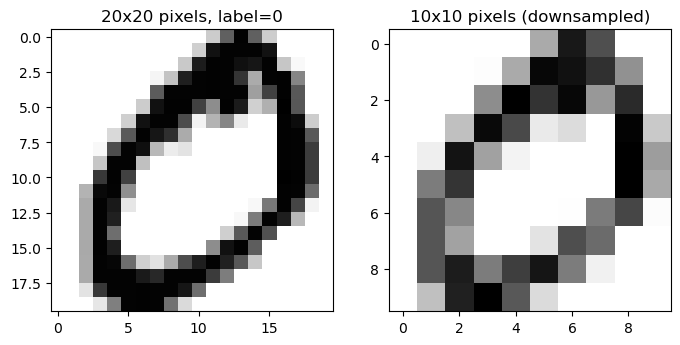

In [34]:
# Initialize MNIST data reader
mndata = MNIST('data')
mndata.gz = True  # Handle gzipped files

# Take only certain digits
Digits = array([0,1,2])
nDigits = len(Digits)

# Load and filter labels
images, labels = mndata.load_training()
labels = np.array(labels)
images = np.array(images).reshape(-1, 28, 28)

# Filter for desired digits
digs = []
for i in range(len(labels)):
    if labels[i] in Digits:
        digs.append(i)

# Filter labels and images
labels = labels[digs]
images = images[digs,4:-4,4:-4]   # start with 20X20 pixel images

# Downsample to 10x10 using mean pooling
from skimage.measure import block_reduce
Dimages = block_reduce(images, (1,2,2), func=mean)  # downsample images to 10X10 pixels

# Define training and test sets
TrainSize = 400
TestSize = 600

X_Train_Set = Dimages[:TrainSize]
Y_Train_Set = labels[:TrainSize]
X_Test_Set = Dimages[TrainSize:TrainSize+TestSize]
Y_Test_Set = labels[TrainSize:TrainSize+TestSize]

# Plot example
ex = 0
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(images[ex,:,:] * -1, cmap='gray')
axs[0].set_title(f'20x20 pixels, label={labels[ex]}')
axs[1].imshow(Dimages[ex,:,:] * -1, cmap='gray')
axs[1].set_title('10x10 pixels (downsampled)')
plt.show()

In [35]:
# define training set
TrainSize = 400
X_Train_Set = Dimages[:TrainSize]
Y_Train_Set = labels[:TrainSize]

# define test set
TestSize = 600
X_Test_Set = Dimages[TrainSize:TrainSize+TestSize]
Y_Test_Set = labels[TrainSize:TrainSize+TestSize]

# number of sources and targets
nSources = size(X_Train_Set[0])
nTargets = nDigits
nGrounds = 1

In [36]:
# create random grapgh
nNodes = nSources * 3    # number of network nodes
nEdges = nNodes * 5      # number of network edges
lNode, rNode = array([choice(array(nNodes), size=2, replace=False) for i in range(nEdges)]).T

# create sparse network structures

# Choose input and output nodes
# RNodes = choice(arange(nNodes), size=nSources+nTargets+nGrounds, replace=False)
# SourceNodes = RNodes[:nSources]
# TargetNodes = RNodes[nSources:nSources+nTargets]
# GroundNodes = [RNodes[-1]]
# SourceEdges = []
# TargetEdges = []

# Choose input and output edges
REdges = choice(arange(1, nEdges), size=nSources+nTargets, replace=False)
SourceEdges = REdges[:nSources]
TargetEdges = REdges[nSources:]
GroundNodes = [0]
SourceNodes = []
TargetNodes = []

# Make sparse structures for network response computation
from SparseLinearNetwork import SparseIncidenceConstraintMatrix
sDMF, sDMC, sBLF, sBLC, sDot = SparseIncidenceConstraintMatrix(SourceNodes, SourceEdges, TargetNodes, TargetEdges, GroundNodes, nNodes, lNode, rNode)
print('Network size: ', nNodes,' Nodes, ', nEdges, ' Edges')

NameError: name 'choice' is not defined

In [ ]:
# Training voltage inputs
ff = zeros([TrainSize, sDMF.shape[1]])     # free constraints templeate vector
ff[:, nNodes+nGrounds:] = reshape(X_Train_Set, [TrainSize, nSources])

# Test voltage inputs
ffT = zeros([TestSize, sDMF.shape[1]])     # free constraints templeate vector
ffT[:, nNodes+nGrounds:] = reshape(X_Test_Set, [TestSize, nSources])

# initialize conductance values
import numpy.random as rand
from scipy.sparse import spdiags, diags
K0 = 1. + (rand.rand(nEdges) - 0.5) * 0.1
sK0 = spdiags(K0, 0, nEdges, nEdges, format='csc')          # diagonal matrix with the conductance values on the diagonal elements

# Compute network responses on training set
import pypardiso
PF = pypardiso.spsolve(sBLF + sDMF.T*sK0*sDMF, ff.T)
FST = sDot.dot(PF)
MFST = mean(FST, 1)  # mean response for all training examples

# use mean response to training examples to set desired target values
fc = zeros([TrainSize, sDMC.shape[1]])                      # clamped constraints template vector
Desired = zeros([TrainSize, sDMC.shape[1]-sDMF.shape[1]])   # Desired outputs
DesiredT = zeros([TestSize, sDMC.shape[1]-sDMF.shape[1]])   # Desired test outputs

Targets = zeros([nDigits, nDigits])
amp = 2.
for i in range(nDigits):
    ids = where(Y_Train_Set==Digits[i])[0]
    # Clamping targets for each class
    Targets[i] = MFST + amp * (mean(FST[:,ids], 1) - MFST)

    fc[ids, nNodes+nGrounds:nNodes+nGrounds+nSources] = reshape(X_Train_Set[ids], [len(ids), nSources])
    fc[ids, nNodes+nGrounds+nSources:] = Targets[i]
    Desired[ids] = Targets[i]

    idsT = where(Y_Test_Set==Digits[i])[0]
    DesiredT[ids] = Targets[i]


In [ ]:
# Initial network response to training examples
PF = pypardiso.spsolve(sBLF + sDMF.T*sK0*sDMF, ff.T)
# Response of the output degrees of freedom (output nodes\edges)
FST = (sDot.dot(PF)).T
# Distance between output responses to each one of the digit classes
Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TrainSize)] for c in range(nDigits)], 2)))
# Class is decided by the closest digit target to the output response
minDs = argmin(Ds, axis=0)
# Classification accuracy
Chg = (minDs != Y_Train_Set)
Acc = sum(1-Chg)/TrainSize

# Same as above, but for test examples
PF = pypardiso.spsolve(sBLF + sDMF.T*sK0*sDMF, ffT.T)
FST = (sDot.dot(PF)).T
Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TestSize)] for c in range(nDigits)], 2)))
minDs = argmin(Ds, axis=0)
Chg = (minDs != Y_Test_Set)
AccT = sum(1-Chg)/TestSize

print('Initial training accuracy: ', round(Acc,3))
print('Initial test accuracy: ',  round(AccT,3))

Initial training accuracy:  0.68
Initial test accuracy:  0.658


In [ ]:
# Training using coupled learning

K = K0.copy()
sK = spdiags(K, 0, nEdges, nEdges, format='csc')

Steps = 80000    # number of steps
eta = 1.e-3      # nudge parameter
lr = 1.e-4       # learning rate

# Training errors and accuracies
Cs = []
Accs = []

# Responses and accuracy of training set
PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ff.T)
C = 0.5 * sum((sDot.dot(PF) - Desired.T)**2)/TrainSize
FST = (sDot.dot(PF)).T
Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TrainSize)] for c in range(nDigits)], 2)))
minDs = argmin(Ds, axis=0)
Chg = (minDs != Y_Train_Set)
Acc = sum(1-Chg)/TrainSize
Cs.append(C)
Accs.append(Acc)

# Test errors and accuracies
CTs = []
AccTs = []

# Responses and accuracy of test set
PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ffT.T)
C = 0.5 * sum((sDot.dot(PF) - DesiredT.T)**2)/TestSize
FST = (sDot.dot(PF)).T
Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TestSize)] for c in range(nDigits)], 2)))
minDs = argmin(Ds, axis=0)
Chg = (minDs != Y_Test_Set)
AccT = sum(1-Chg)/TestSize
CTs.append(C)
AccTs.append(AccT)

print('Step 0  ;  Training accuracy: ', round(Acc,3), ',  Test accuracy: ', round(AccT,3))

BestK = K0
BestAccT = AccT

printSteps = 50    # print accuracy every number of training steps

#iterate over training steps
for steps in range(1,Steps+1):        
    # Free state
    PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ff.T)
    FST = (sDot.dot(PF)).T
    DPF = sDMF.dot(PF)
    PPF = DPF**2

    # correctly classified input examples
    Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TrainSize)] for c in range(nDigits)], 2)))
    minDs = argmin(Ds, axis=0)
    Chg = (minDs != Y_Train_Set)

    # Clamped state computation
    #FST = (sDot.dot(PF)).T
    Nudge = FST.T + eta * (Desired.T - FST.T)
    fc[:,-nDigits:] = Nudge.T
    PC = pypardiso.spsolve(sBLC + sDMC.T*sK*sDMC, fc.T)
    DPC = sDMC.dot(PC)
    PPC = DPC**2

    # Coupled learning rule
    DKL = + 0.5 * (PPC - PPF) / eta
    K2 = K - lr * mean(DKL * Chg, axis=1) * TrainSize/(sum(Chg)+1.e-10)   # Cross entropy rule
    K2 = K2.clip(1.e-6,1.e4)

    DK = K2-K
    K = K2
    sK = spdiags(K, 0, nEdges, nEdges, format='csc')
    
    if steps%printSteps == 0:
        # Training errors and accuracies
        PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ff.T)
        C = 0.5 * sum((sDot.dot(PF) - Desired.T)**2)/TrainSize
        FST = (sDot.dot(PF)).T
        Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TrainSize)] for c in range(nDigits)], 2)))
        minDs = argmin(Ds, axis=0)
        Chg = (minDs != Y_Train_Set)
        Acc = sum(1-Chg)/TrainSize
        Cs.append(C)
        Accs.append(Acc)

        # Test errors and accuracies
        PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ffT.T)
        C = 0.5 * sum((sDot.dot(PF) - DesiredT.T)**2)/TestSize
        FST = (sDot.dot(PF)).T
        Ds = array(sqrt(sum([[(Targets[c] - FST[i])**2 for i in range(TestSize)] for c in range(nDigits)], 2)))
        minDs = argmin(Ds, axis=0)
        Chg = (minDs != Y_Test_Set)
        AccT = sum(1-Chg)/TestSize
        CTs.append(C)
        AccTs.append(AccT)

        print('Step', steps, '  ;  Training accuracy: ', round(Acc,3), ',  Test accuracy: ', round(AccT,3))

        if AccT > BestAccT:
            BestAccT = AccT
            BestK = K
            print('Current best test accuracy: ', round(AccT,3))

        if Acc == 1.:
            break


Step 0  ;  Training accuracy:  0.68 ,  Test accuracy:  0.658
Step 50   ;  Training accuracy:  0.852 ,  Test accuracy:  0.883
Current best test accuracy:  0.883
Step 100   ;  Training accuracy:  0.89 ,  Test accuracy:  0.908
Current best test accuracy:  0.908
Step 150   ;  Training accuracy:  0.922 ,  Test accuracy:  0.937
Current best test accuracy:  0.937
Step 200   ;  Training accuracy:  0.92 ,  Test accuracy:  0.942
Current best test accuracy:  0.942
Step 250   ;  Training accuracy:  0.935 ,  Test accuracy:  0.948
Current best test accuracy:  0.948
Step 300   ;  Training accuracy:  0.948 ,  Test accuracy:  0.95
Current best test accuracy:  0.95
Step 350   ;  Training accuracy:  0.942 ,  Test accuracy:  0.945
Step 400   ;  Training accuracy:  0.935 ,  Test accuracy:  0.937
Step 450   ;  Training accuracy:  0.94 ,  Test accuracy:  0.928
Step 500   ;  Training accuracy:  0.962 ,  Test accuracy:  0.94
Step 550   ;  Training accuracy:  0.952 ,  Test accuracy:  0.928
Step 600   ;  Trainin

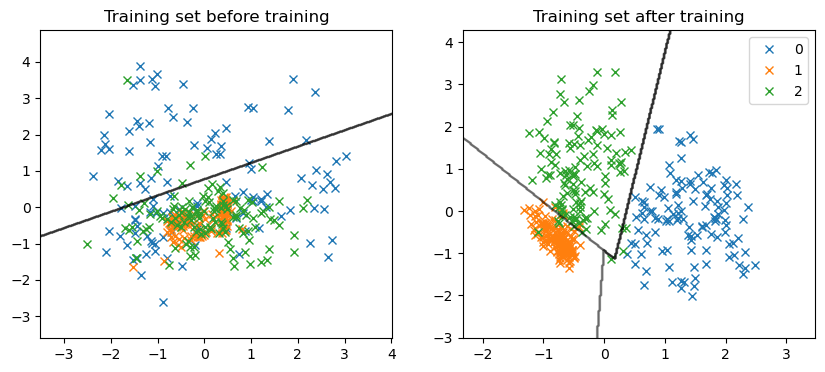

In [ ]:
# Classification on training set

from sklearn.decomposition import PCA
from sklearn import svm

fig, axes = plt.subplots(1,2, figsize=(10,4))

# Before training
sK = spdiags(K0, 0, nEdges, nEdges, format='csc')
PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ff.T)
pca = PCA(n_components=2, whiten=True)
pca.fit(sDot.dot(PF).T)
X_pca = pca.transform(sDot.dot(PF).T)
for i in range(nDigits):
    ids = (Y_Train_Set == Digits[i])
    axes[0].plot(X_pca.T[0][ids], X_pca.T[1][ids], 'x', label=Digits[i])
axes[0].set_title('Training set before training')

reduced_data = pca.transform(sDot.dot(PF).T)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model = svm.SVC(kernel='linear')
clf = model.fit(reduced_data, Y_Train_Set)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[0].contour(xx,yy,Z,colors='k',alpha=0.2)


# After training
sK = spdiags(BestK, 0, nEdges, nEdges, format='csc')
PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ff.T)
pca = PCA(n_components=2, whiten=True)
pca.fit(sDot.dot(PF).T)
X_pca = pca.transform(sDot.dot(PF).T)
for i in range(nDigits):
    ids = (Y_Train_Set == Digits[i])
    axes[1].plot(X_pca.T[0][ids], X_pca.T[1][ids], 'x', label=Digits[i])
axes[1].legend()
axes[1].set_title('Training set after training')

reduced_data = pca.transform(sDot.dot(PF).T)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model = svm.SVC(kernel='linear')
clf = model.fit(reduced_data, Y_Train_Set)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[1].contour(xx,yy,Z,colors='k',alpha=0.2)

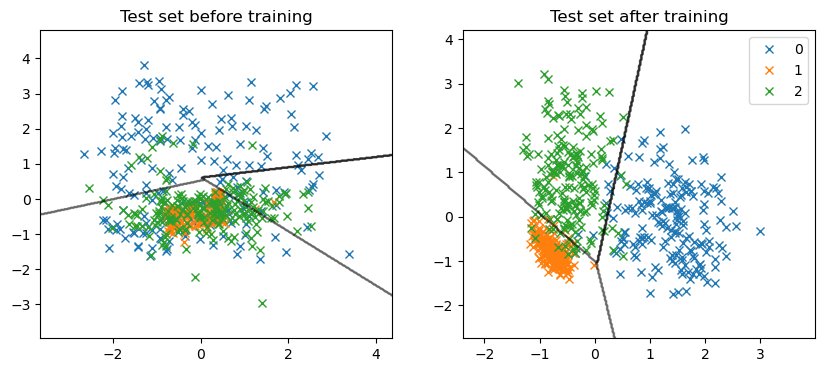

In [ ]:
# Classification on test set

from sklearn.decomposition import PCA
from sklearn import svm

fig, axes = plt.subplots(1,2, figsize=(10,4))

# Before training
sK = spdiags(K0, 0, nEdges, nEdges, format='csc')
PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ffT.T)
pca = PCA(n_components=2, whiten=True)
pca.fit(sDot.dot(PF).T)
X_pca = pca.transform(sDot.dot(PF).T)
for i in range(nDigits):
    ids = (Y_Test_Set == Digits[i])
    axes[0].plot(X_pca.T[0][ids], X_pca.T[1][ids], 'x', label=Digits[i])
axes[0].set_title('Test set before training')

reduced_data = pca.transform(sDot.dot(PF).T)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model = svm.SVC(kernel='linear')
clf = model.fit(reduced_data, Y_Test_Set)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[0].contour(xx,yy,Z,colors='k',alpha=0.2)


# After training
sK = spdiags(BestK, 0, nEdges, nEdges, format='csc')
PF = pypardiso.spsolve(sBLF + sDMF.T*sK*sDMF, ffT.T)
pca = PCA(n_components=2, whiten=True)
pca.fit(sDot.dot(PF).T)
X_pca = pca.transform(sDot.dot(PF).T)
for i in range(nDigits):
    ids = (Y_Test_Set == Digits[i])
    axes[1].plot(X_pca.T[0][ids], X_pca.T[1][ids], 'x', label=Digits[i])
axes[1].legend()
axes[1].set_title('Test set after training')

reduced_data = X_pca
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model = svm.SVC(kernel='linear')
clf = model.fit(reduced_data, Y_Test_Set)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[1].contour(xx,yy,Z,colors='k',alpha=0.2)

Text(0.5, 1.0, 'Network after training\n Test accuracy: 0.962')

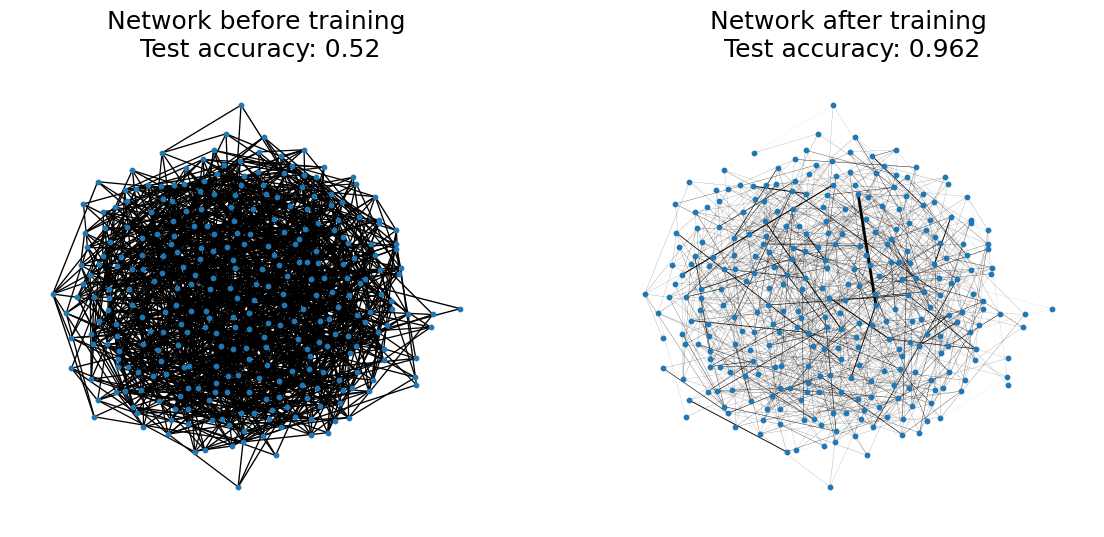

In [ ]:
# Network graphs

import networkx as nx
G = nx.from_edgelist(c_[lNode,rNode])

fig, axes = plt.subplots(1,2, figsize=(14,6))

K = K0
nx.draw_kamada_kawai(G, ax=axes[0], node_size=10, width=1.*K/K.max())
axes[0].set_title('Network before training\n Test accuracy: '+ str(round(AccTs[0],3)), size=18)

K = BestK
nx.draw_kamada_kawai(G, ax=axes[1], node_size=10, width=2.*K/K.max())
axes[1].set_title('Network after training\n Test accuracy: '+ str(round(BestAccT,3)), size=18)